In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

--2022-01-23 08:57:54--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.96, 99.86.38.106, 99.86.38.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2022-01-23 08:57:54 (65.1 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re

lines = pd.read_csv('data/eng-fra.txt', names=['src', 'tar'], sep='\t')
print(f'[1] {len(lines)}') # 13만개

# fra를 src, eng를 tar로 변경
lines = lines.rename(columns={'src': 'tar', 'tar': 'src'})
lines = lines.reindex(columns=['src', 'tar'])

# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

lines.src = lines.src.apply(lambda x : normalizeString(x))
lines.tar = lines.tar.apply(lambda x : normalizeString(x))

# 전체 데이터셋이 너무 많으니 "I am" 또는 "He is"와 같은 형태의 문장만 필터하여 학습
# 또, 문장에 포함된 단어의 수가 10개 이하인 문장만 학습

# rule 1
MAX_LENGTH = 6

# rule 2
eng_prefixes = (
    "i am ", "i m ", # 어퍼스트로피(')는 이미 normalize 과정에서 필터됨
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

filter_TF = []
for idx in lines.index:
  is_underMaxLength = len(lines.loc[idx, 'src'].split(' ')) <= MAX_LENGTH \
                and len(lines.loc[idx, 'tar'].split(' ')) <= MAX_LENGTH
  is_prefix = lines.loc[idx, 'tar'].startswith(eng_prefixes)
  filter_TF.append(is_underMaxLength and is_prefix)

lines = lines[filter_TF]
print(f'[2] {len(lines)}')

# 소스 언어의 맨뒤에 <eos>  토큰 추가
# 타겟 언어의 앞뒤로 <sos>, <eos> 토큰 추가

lines.src = lines.src.apply(lambda x : x + ' <eos>')
lines.tar = lines.tar.apply(lambda x : '<sos> '+ x + ' <eos>')
MAX_LENGTH += 2
print(lines.sample(10))

[1] 135842
[2] 5318
                                      src                                         tar
19131          il est fort erudit . <eos>            <sos> he is very learned . <eos>
2046               je suis voyant . <eos>                   <sos> i m psychic . <eos>
22400     c est toi la professeur . <eos>            <sos> you re the teacher . <eos>
5452         elles sont en colere . <eos>                 <sos> they re angry . <eos>
3303         je suis trop affaire . <eos>                  <sos> i m too busy . <eos>
71807      ils parlent de musique . <eos>  <sos> they are talking about music . <eos>
2855      il est tellement mignon ! <eos>                  <sos> he s so cute . <eos>
17762  nous sommes tous retraites . <eos>             <sos> we re all retired . <eos>
2008                   je conduis . <eos>                   <sos> i m driving . <eos>
3966                 t es plantee . <eos>                  <sos> you re stuck . <eos>


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
SOS_token = 0
EOS_token = 1

# vocab 정보를 저장하는 helper class
class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {'<sos>': 0, '<eos>': 1}
    self.word2count = {}
    self.index2word = {0: '<sos>', 1: '<eos>'}
    self.n_words = 2
  
  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)
  
  def addWord(self, word):
    if word == '<sos>' or word == '<eos>': return
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1

# Lang 인스턴스 생성
input_lang = Lang('eng')
output_lang = Lang('fra')

for idx, row in lines.iterrows():
  input_lang.addSentence(row['src'])
  output_lang.addSentence(row['tar'])

print(input_lang.n_words)
print(output_lang.n_words)

2579
1573


In [ ]:
def sentenceToTensor(lang, sentence):
  integer_encode = [lang.word2index[word] for word in sentence.split(' ')]
  return torch.LongTensor(integer_encode).to(device).view(-1, 1)

training_pairs = []
for idx, row in lines.iterrows():
  training_pairs.append((
    sentenceToTensor(input_lang, row['src']),
    sentenceToTensor(output_lang, row['tar'])
  ))

print(len(training_pairs))
print(training_pairs[0])

5318
(tensor([[2],
        [3],
        [4],
        [5],
        [1]], device='cuda:0'), tensor([[0],
        [2],
        [3],
        [4],
        [1]], device='cuda:0'))


# 모델 정의

In [ ]:
class EncoderRNN(nn.Module):
  # input_size = # of words in input language
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size # size of context vector
    
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1, 1, -1) # TODO: 여기 view는 어떤 역할?
    output, hidden = self.gru(embedded, hidden)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
  # output_size = # of words in output language
  def __init__(self, output_size, hidden_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.fc = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, input, hidden):
    output = self.embedding(input).view(1, 1, -1)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.fc(output[0])
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

# 모델 학습

In [ ]:
def train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, pair):
  loss = 0

  # encoder train
  encoder_optimizer.zero_grad()

  input_tensor = pair[0]
  input_length = input_tensor.size(0)

  encoder_hidden = encoder.initHidden()
  encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
    # MAX_LENGTH = 10
    # encoder의 output을 기록하는 용도

  for ei in range(input_length): # iterate word one-by-one
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] += encoder_output[0, 0]
  
  # decoder train
  decoder_optimizer.zero_grad()

  target_tensor = pair[1]
  target_length = target_tensor.size(0)

  decoder_input = torch.tensor([[SOS_token]], device=device) # <sos> 토큰부터 시작
  decoder_hidden = encoder_hidden

  for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    loss += criterion(decoder_output, target_tensor[di])
    decoder_input = target_tensor[di]  # Teaching forcing: gt를 다음 input으로 넣는다

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return (loss.item() / target_length)

In [ ]:
HIDDEN_SIZE = 256
encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
decoder = DecoderRNN(output_lang.n_words, HIDDEN_SIZE).to(device)

LEARNING_RATE = 0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)

criterion = nn.NLLLoss()

MAX_EPOCH = 40
train_loss_list = []

for epoch in range(1, MAX_EPOCH + 1):
  epoch_loss = 0
  tic = time.time()
  for pair in training_pairs:
    loss = train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, pair)
    epoch_loss += loss

  avg_epoch_loss = epoch_loss / len(training_pairs)
  train_loss_list.append(avg_epoch_loss)
  toc = time.time()

  if epoch % 5 == 0:
    print(f'| epoch: {epoch:3d} | time: {toc - tic:5.1f} sec | loss: {avg_epoch_loss:8.4f}')

| epoch:   5 | time:  60.5 sec | loss:   0.6783
| epoch:  10 | time:  60.5 sec | loss:   0.2288
| epoch:  15 | time:  60.5 sec | loss:   0.0727
| epoch:  20 | time:  60.6 sec | loss:   0.0375
| epoch:  25 | time:  60.8 sec | loss:   0.0330
| epoch:  30 | time:  60.5 sec | loss:   0.0317
| epoch:  35 | time:  60.5 sec | loss:   0.0307
| epoch:  40 | time:  61.2 sec | loss:   0.0265


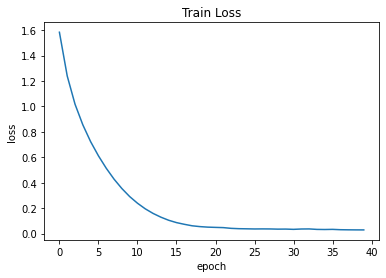

In [ ]:
plt.figure()
plt.title('Train Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(train_loss_list)

## 모델 평가

In [ ]:
# evaluate
def translateSentence(encoder, decoder, sentence):
  # encoder
  encoder.eval()
  input_tensor = sentenceToTensor(input_lang, sentence)
  input_length = input_tensor.size()[0]
  encoder_hidden = encoder.initHidden()

  encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] += encoder_output[0, 0]

  # decoder
  decoder.eval()
  decoder_hidden = encoder_hidden
  decoder_input = torch.tensor([[SOS_token]], device=device)
  decoded_words = []

  for di in range(MAX_LENGTH):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    topv, topi = decoder_output.topk(1)
    decoder_input = topi.squeeze().detach()

    if topi.item() == EOS_token:
      decoded_words.append('<eos>')
      break
    else:
      decoded_words.append(output_lang.index2word[topi.item()])

  return decoded_words

for _ in range(10):
  random_index = random.choice(lines.index)
  input_sentence = lines.loc[random_index, 'src']
  target_sentence = lines.loc[random_index, 'tar']
  output_sentence = ' '.join(translateSentence(encoder, decoder, input_sentence))

  input_sentence = input_sentence.replace('<eos>', '').replace('<sos>', '')
  target_sentence = target_sentence.replace('<eos>', '').replace('<sos>', '')
  output_sentence = output_sentence.replace('<eos>', '').replace('<sos>', '')

  print(f'eng: {input_sentence}')
  print(f'fra(gt): {target_sentence}')
  print(f'fra(pred): {output_sentence}')
  print('-' * 50)

eng: tu es pathetique . 
fra(gt):  you re pathetic . 
fra(pred):  you re completely delusional . 
--------------------------------------------------
eng: vous etes tres habile . 
fra(gt):  you re very clever . 
fra(pred):  you re very sophisticated . 
--------------------------------------------------
eng: tu es creatif . 
fra(gt):  you re creative . 
fra(pred):  you re embarrassing yourself . 
--------------------------------------------------
eng: tu es fort bon . 
fra(gt):  you re very good . 
fra(pred):  you re very sophisticated . 
--------------------------------------------------
eng: vous etes tres intelligente . 
fra(gt):  you re very intelligent . 
fra(pred):  you re very sophisticated . 
--------------------------------------------------
eng: je suis fou de vous . 
fra(gt):  i m crazy about you . 
fra(pred):  i m crazy about you . 
--------------------------------------------------
eng: vous etes courtois . 
fra(gt):  you re courteous . 
fra(pred):  you re unbelievably stupi

# teaching force 모델 학습

In [ ]:
teacher_forcing_ratio = 0.5

def trainWithRandomTeachingForce(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, pair):
  loss = 0

  # encoder train
  encoder_optimizer.zero_grad()

  input_tensor = pair[0]
  input_length = input_tensor.size(0)

  encoder_hidden = encoder.initHidden()
  encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
    # MAX_LENGTH = 10
    # encoder의 output을 기록하는 용도

  for ei in range(input_length): # iterate word one-by-one
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] += encoder_output[0, 0]
  
  # decoder train
  decoder_optimizer.zero_grad()

  target_tensor = pair[1]
  target_length = target_tensor.size(0)

  decoder_input = torch.tensor([[SOS_token]], device=device) # <sos> 토큰부터 시작
  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing:
    for di in range(target_length):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      loss += criterion(decoder_output, target_tensor[di])
      decoder_input = target_tensor[di]  # Teacher forcing: gt를 다음 input으로 넣는다
  else:
    for di in range(target_length):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      loss += criterion(decoder_output, target_tensor[di])
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()  # Teacher forcing: gt를 다음 input으로 넣는다

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return (loss.item() / target_length)

In [ ]:
HIDDEN_SIZE = 256
encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
decoder = DecoderRNN(output_lang.n_words, HIDDEN_SIZE).to(device)

LEARNING_RATE = 0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)

criterion = nn.NLLLoss()

MAX_EPOCH = 40
train_loss_list = []

for epoch in range(1, MAX_EPOCH + 1):
  epoch_loss = 0
  tic = time.time()
  for pair in training_pairs:
    loss = trainWithRandomTeachingForce(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, pair)
    epoch_loss += loss

  avg_epoch_loss = epoch_loss / len(training_pairs)
  train_loss_list.append(avg_epoch_loss)
  toc = time.time()

  if epoch % 5 == 0:
    print(f'| epoch: {epoch:3d} | time: {toc - tic:5.1f} sec | loss: {avg_epoch_loss:8.4f}')


| epoch:   5 | time:  61.6 sec | loss:   0.7926
| epoch:  10 | time:  62.1 sec | loss:   0.2586
| epoch:  15 | time:  61.6 sec | loss:   0.0792
| epoch:  20 | time:  61.4 sec | loss:   0.0390
| epoch:  25 | time:  61.7 sec | loss:   0.0359
| epoch:  30 | time:  62.3 sec | loss:   0.0372
| epoch:  35 | time:  62.3 sec | loss:   0.0343
| epoch:  40 | time:  62.0 sec | loss:   0.0347


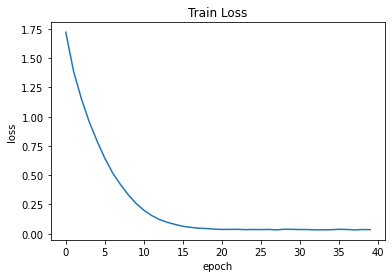

In [ ]:
plt.figure()
plt.title('Train Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(train_loss_list)

## 모델 평가

In [ ]:
for _ in range(10):
  random_index = random.choice(lines.index)
  input_sentence = lines.loc[random_index, 'src']
  target_sentence = lines.loc[random_index, 'tar']
  output_sentence = ' '.join(translateSentence(encoder, decoder, input_sentence))

  input_sentence = input_sentence.replace('<eos>', '').replace('<sos>', '')
  target_sentence = target_sentence.replace('<eos>', '').replace('<sos>', '')
  output_sentence = output_sentence.replace('<eos>', '').replace('<sos>', '')

  print(f'eng: {input_sentence}')
  print(f'fra(gt): {target_sentence}')
  print(f'fra(pred): {output_sentence}')
  print('-' * 50)

eng: je fais de mon mieux . 
fra(gt):  i am doing my best . 
fra(pred):  i am doing my best . 
--------------------------------------------------
eng: vous etes vraiment embetant . 
fra(gt):  you re really annoying . 
fra(pred):  you re really annoying . 
--------------------------------------------------
eng: ils ont tous disparu . 
fra(gt):  they re all gone . 
fra(pred):  they re all working together . 
--------------------------------------------------
eng: je suis un artiste . 
fra(gt):  i m an artist . 
fra(pred):  i am an artist artist . 
--------------------------------------------------
eng: il est constamment insatisfait . 
fra(gt):  he s always dissatisfied . 
fra(pred):  he s always dissatisfied . 
--------------------------------------------------
eng: tu es trop confiant . 
fra(gt):  you re too trusting . 
fra(pred):  you re always being too . 
--------------------------------------------------
eng: nous reduisons la voilure . 
fra(gt):  we re downsizing . 
fra(pred):  we

# Attention 모델

In [ ]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, output_size, hidden_size):
    super(AttnDecoderRNN, self).__init__()
    self.embbed_size = hidden_size # same as hidden size
    self.hidden_size = hidden_size 
    self.output_size = output_size # of words in output language
  
    self.embedding = nn.Embedding(self.output_size, self.embbed_size)
    self.gru = nn.GRU(self.embbed_size, self.hidden_size)

    # attention
    self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)

    self.fc = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1, 1, -1)
    embedded = F.relu(embedded)

    output, hidden = self.gru(embedded, hidden)
    
    # attention
    attn_score = encoder_outputs.matmul(hidden.view((self.hidden_size, 1)))
    attn_distribution = F.softmax(attn_score, dim = 0)
    attn_value = torch.sum(encoder_outputs * attn_distribution, dim = 0).view(1, 1, self.hidden_size) # 가중합

    concat = torch.cat((attn_value, hidden), dim = 2)
    output = self.attn(concat)
    output = torch.tanh(output)

    output = self.fc(output[0])
    output = self.softmax(output)

    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
teacher_forcing_ratio = 0.5

def trainAttentionModel(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, pair):
  loss = 0

  # encoder train
  encoder_optimizer.zero_grad()

  input_tensor = pair[0]
  input_length = input_tensor.size(0)

  encoder_hidden = encoder.initHidden()
  encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
    # MAX_LENGTH = 10
    # encoder의 output을 기록하는 용도

  for ei in range(input_length): # iterate word one-by-one
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] += encoder_output[0, 0]
  
  # decoder train
  decoder_optimizer.zero_grad()

  target_tensor = pair[1]
  target_length = target_tensor.size(0)

  decoder_input = torch.tensor([[SOS_token]], device=device) # <sos> 토큰부터 시작
  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing:
    for di in range(target_length):
      decoder_output, decoder_hidden \
        = decoder(decoder_input, decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[di])
      decoder_input = target_tensor[di]  # Teacher forcing: gt를 다음 input으로 넣는다
  else:
    for di in range(target_length):
      decoder_output, decoder_hidden \
        = decoder(decoder_input, decoder_hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[di])
      topv, topi = decoder_output.topk(1)
      decoder_input = topi.squeeze().detach()  # Teacher forcing: gt를 다음 input으로 넣는다

  loss.backward()

  encoder_optimizer.step()
  decoder_optimizer.step()

  return (loss.item() / target_length)

In [10]:
HIDDEN_SIZE = 256
encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
decoder = AttnDecoderRNN(output_lang.n_words, HIDDEN_SIZE).to(device)

LEARNING_RATE = 0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)

criterion = nn.NLLLoss()

MAX_EPOCH = 40
train_loss_list = []

for epoch in range(1, MAX_EPOCH + 1):
  epoch_loss = 0
  tic = time.time()
  for pair in training_pairs:
    loss = trainAttentionModel(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, pair)
    epoch_loss += loss

  avg_epoch_loss = epoch_loss / len(training_pairs)
  train_loss_list.append(avg_epoch_loss)
  toc = time.time()

  if epoch % 5 == 0:
    print(f'| epoch: {epoch:3d} | time: {toc - tic:5.1f} sec | loss: {avg_epoch_loss:8.4f}')


| epoch:   5 | time:  96.0 sec | loss:   0.6167
| epoch:  10 | time:  95.6 sec | loss:   0.1541
| epoch:  15 | time:  95.5 sec | loss:   0.0708
| epoch:  20 | time:  95.6 sec | loss:   0.0541
| epoch:  25 | time:  95.0 sec | loss:   0.0458
| epoch:  30 | time:  94.1 sec | loss:   0.0436
| epoch:  35 | time:  94.1 sec | loss:   0.0426
| epoch:  40 | time:  94.1 sec | loss:   0.0444


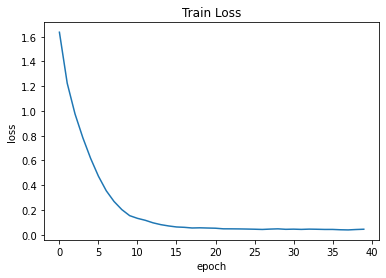

In [11]:
plt.figure()
plt.title('Train Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(train_loss_list)

In [14]:
# evaluate
def translateAttention(encoder, decoder, sentence):
  # encoder
  encoder.eval()
  input_tensor = sentenceToTensor(input_lang, sentence)
  input_length = input_tensor.size()[0]
  encoder_hidden = encoder.initHidden()

  encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] += encoder_output[0, 0]

  # decoder
  decoder.eval()
  decoder_hidden = encoder_hidden
  decoder_input = torch.tensor([[SOS_token]], device=device)
  decoded_words = []

  for di in range(MAX_LENGTH):
    decoder_output, decoder_hidden \
      = decoder(decoder_input, decoder_hidden, encoder_outputs)
    topv, topi = decoder_output.topk(1)
    decoder_input = topi.squeeze().detach()

    if topi.item() == EOS_token:
      decoded_words.append('<eos>')
      break
    else:
      decoded_words.append(output_lang.index2word[topi.item()])

  return decoded_words

for _ in range(10):
  random_index = random.choice(lines.index)
  input_sentence = lines.loc[random_index, 'src']
  target_sentence = lines.loc[random_index, 'tar']
  output_sentence = ' '.join(translateAttention(encoder, decoder, input_sentence))

  input_sentence = input_sentence.replace('<eos>', '').replace('<sos>', '')
  target_sentence = target_sentence.replace('<eos>', '').replace('<sos>', '')
  output_sentence = output_sentence.replace('<eos>', '').replace('<sos>', '')

  print(f'eng: {input_sentence}')
  print(f'fra(gt): {target_sentence}')
  print(f'fra(pred): {output_sentence}')
  print('-' * 50)

eng: je suis un nouvel etudiant . 
fra(gt):  i am a new student . 
fra(pred):  i am a new student . 
--------------------------------------------------
eng: je suis creve . 
fra(gt):  i am tired . 
fra(pred):  i am exhausted . 
--------------------------------------------------
eng: je suis tres desoriente . 
fra(gt):  i m all confused . 
fra(pred):  i m being being all . 
--------------------------------------------------
eng: il fait du patin . 
fra(gt):  he is skating . 
fra(pred):  he is riding the problem . 
--------------------------------------------------
eng: nous sommes bourrees . 
fra(gt):  we re smashed . 
fra(pred):  we re plastered . 
--------------------------------------------------
eng: elles sont ennuyeuses . 
fra(gt):  they re boring . 
fra(pred):  they re bad . 
--------------------------------------------------
eng: vous etes tres contrariees . 
fra(gt):  you re very upset . 
fra(pred):  you re very skeptical . 
--------------------------------------------------
en